In [0]:
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from glob import glob 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import VGG16, preprocess_input
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.manifold import TSNE

In [3]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate \
  http://madm.dfki.de/files/sentinel/EuroSAT.zip \
  -O /tmp/eurosat.zip

--2020-02-11 16:49:32--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘/tmp/eurosat.zip’

/tmp/eurosat.zip    100%[===================>]  89.91M  10.7MB/s    in 16s     

2020-02-11 16:49:49 (5.67 MB/s) - ‘/tmp/eurosat.zip’ saved [94280567/94280567]



In [0]:
#Unzip the file in '/tmp'
local_zip = '/tmp/eurosat.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
#Split the data into train, valid, test folders
base_dir = "/tmp/2750"

In [0]:
Classes = ["AnnualCrop","HerbaceousVegetation","Industrial","PermanentCrop","River","Forest","Highway","Pasture","Residential","SeaLake"]

In [0]:
LR = 0.001
BATCH_SIZE = 64
NEPOCHS = 15
IMG_WIDTH, IMG_HEIGHT = 75, 75
VALIDATION_RATIO = 0.2

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip=True,
    
    validation_split=VALIDATION_RATIO) # set validation split

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') 

validation_generator = datagen.flow_from_directory(
    base_dir, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') 

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [0]:
def vgg_model(retrain = False):
    """
    DENSNET model + 1 deep layer 
    """
    baseModel = VGG16(weights="imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
    #If retrain is set to False, freeze the VGG16 layers:
    if retrain == False:
        for layer in baseModel.layers:
	          layer.trainable = False
    x = baseModel.output
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(10, activation="softmax")(x)

    # Configure the model
    model = Model(baseModel.input, x)
    
    return model

In [0]:
model = vgg_model(retrain = True)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

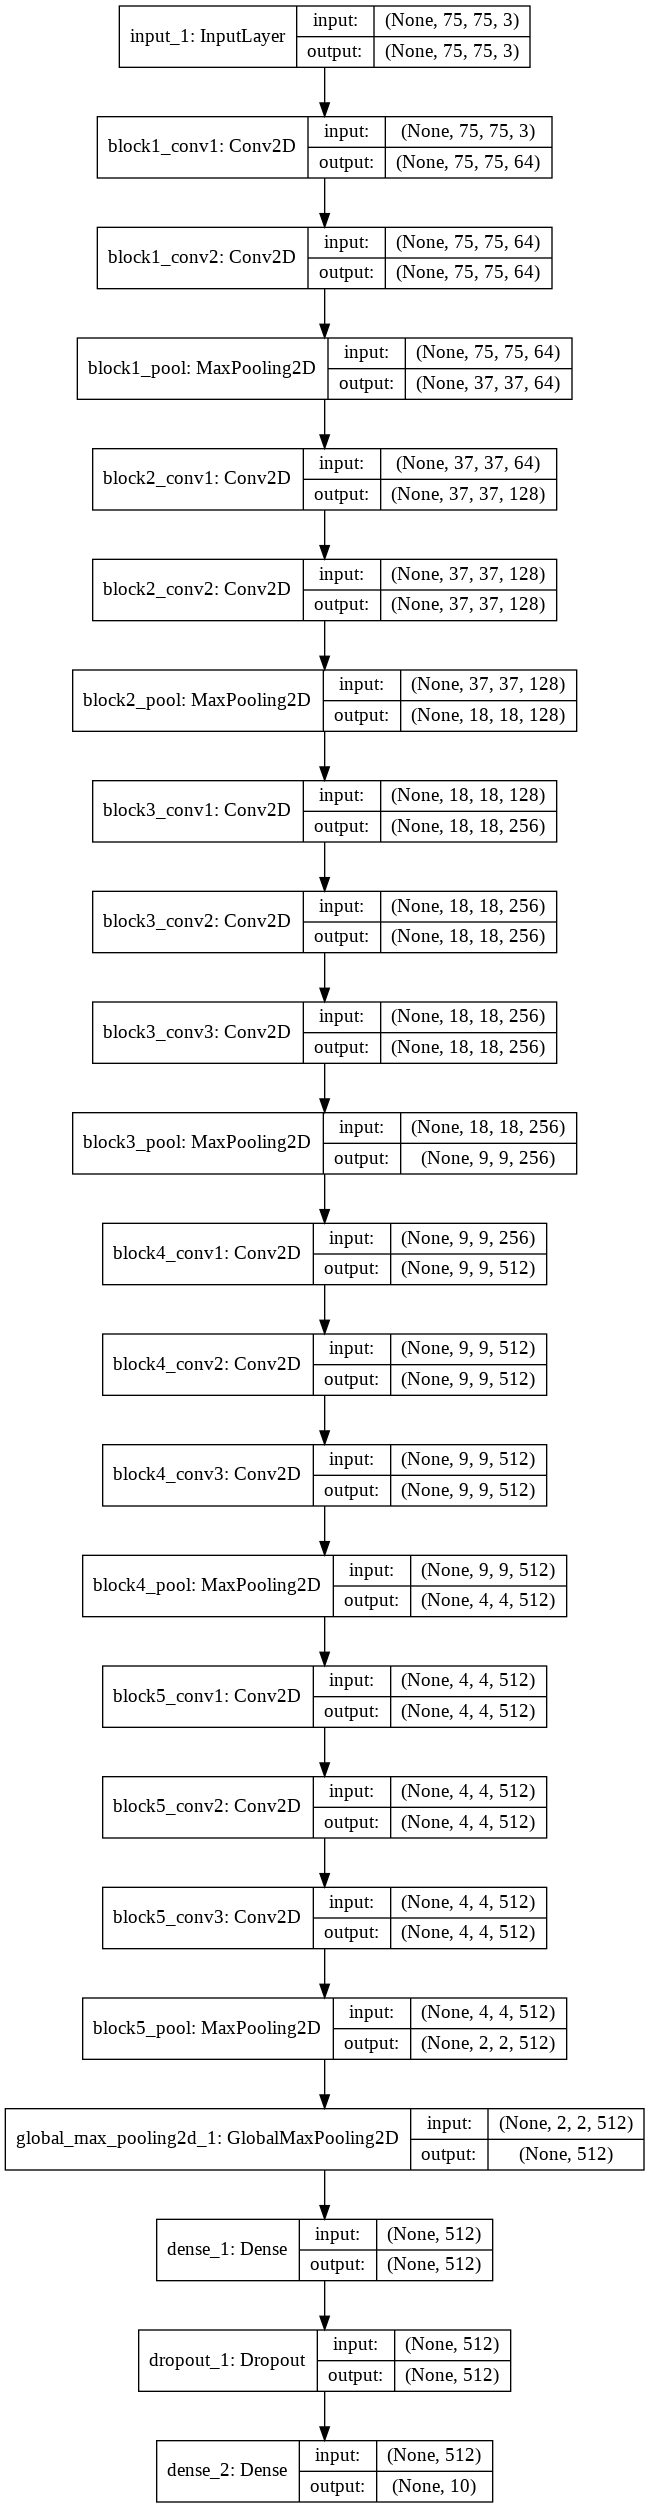

In [12]:
plot_model(model, show_shapes=True)

In [0]:
#Stop the optimization once the validation accuracy converges
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

#Schedul the learning rate
def scheduler(epoch):
  '''
  learning rate scheduler; keeps the learning rate 10^(-3) until 10 and then exponential decrease
  '''
  if epoch < 10:
    return LR
  else:
    return LR * np.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = LR), metrics=['accuracy'])

In [15]:
history = model.fit_generator(train_generator, 
                              epochs=40,
                              validation_data = validation_generator,
                              callbacks=[early_stopping, learning_rate_scheduler], 
                              verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
338/338 [==============================] - 49s 145ms/step - loss: 1.6709 - acc: 0.3393 - val_loss: 1.2385 - val_acc: 0.5306
Epoch 2/40
338/338 [==============================] - 40s 119ms/step - loss: 1.2474 - acc: 0.5249 - val_loss: 1.3301 - val_acc: 0.5613
Epoch 3/40
338/338 [==============================] - 40s 118ms/step - loss: 0.9606 - acc: 0.6423 - val_loss: 0.7024 - val_acc: 0.7431
Epoch 4/40
338/338 [==============================] - 40s 118ms/step - loss: 0.7287 - acc: 0.7398 - val_loss: 0.6002 - val_acc: 0.7981
Epoch 5/40
338/338 [==============================] - 41s 120ms/step - loss: 0.6158 - acc: 0.7849 - val_loss: 0.5300 - val_acc: 0.8156
Epoch 6/40
338/338 [==============================] - 41s 122ms/step - loss: 0.5289 - acc: 0.8193 - val_loss: 0.4604 - val_acc: 0.8346
Epoch 7/40
338/338 [==============================] - 40s 119ms/step - loss: 0.4925 - acc: 0.8

In [0]:
model.save("land_use_vgg.h5")

In [0]:
def plot_history(history):
  
  plt.figure(figsize = (10,6))
  plt.subplot(1,2,1)
  plt.plot(history.history["loss"], label = "loss", linewidth = 3)
  plt.plot(history.history["val_loss"], label = "validation loss", linewidth = 3)
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history["acc"], label = "accuracy", linewidth = 3)
  plt.plot(history.history["val_acc"], label = "validation accuracy", linewidth = 3)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  return None

##Model Perforemance

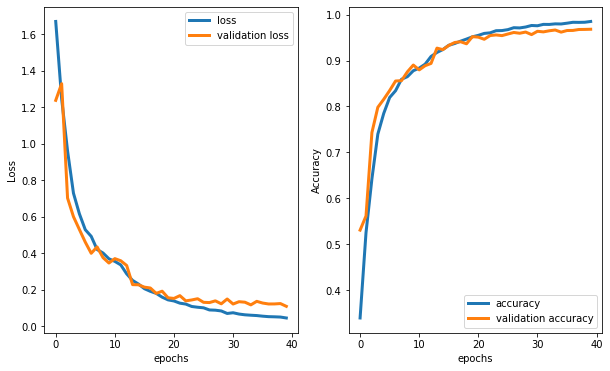

In [62]:
plot_history(history)

In [19]:
testing_generator = datagen.flow_from_directory(
                        base_dir, 
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        class_mode='categorical',
                        shuffle = False,
                        subset='validation')
test_labels = testing_generator.labels
test_preds = model.predict_generator(testing_generator)
#point-estimates!
test_best = test_preds.argmax(axis = -1)

Found 5400 images belonging to 10 classes.


In [20]:
report = classification_report(test_labels,
                               test_best,
                               labels = np.arange(10),
                               target_names = Classes)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.95      0.95       600
HerbaceousVegetation       0.98      0.99      0.98       600
          Industrial       0.95      0.96      0.96       600
       PermanentCrop       0.98      0.97      0.97       500
               River       0.97      0.96      0.97       500
              Forest       0.97      0.93      0.95       400
             Highway       0.93      0.96      0.94       500
             Pasture       0.98      0.99      0.99       600
         Residential       0.97      0.96      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



So compared to our own vanila CNN, adding a deep layer on the top of the VGG16 architecture allows us to achieve a much highr accuracy of 97\%!

##Vizualisation with tSNE

Let's take a look at the activation maps! In particular, let's take the output of top layer before the Softmax layer. For any given image, this output should be 512 dimensional vector. 

Then we use the tSNE algorithm to reduce the dimensionality of these outputs.

This help us figure out how well the Network can separate the different classes (SeaLakes, Forests, etc).

In [0]:
layer_outputs = [layer.output for layer in model.layers][-2]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activation_map = activation_model.predict_generator(testing_generator)

In [77]:
print("shape of the out put matrix is = " , activation_map.shape)

shape of the out put matrix is =  (5400, 512)


In [0]:
activation_normalized = preprocessing.normalize(activation_map)

In [0]:
tsne = TSNE(perplexity=200)
activation_proj = tsne.fit_transform(activation_normalized)

(-42.95425648692724, 46.280542802845204, -47.71147934841392, 43.80902497219321)

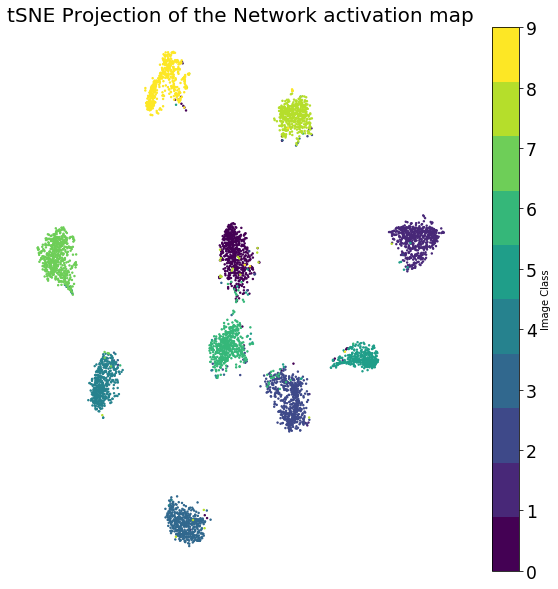

In [76]:
plt.figure(figsize  = (10,10))
plt.scatter(activation_proj[:,0], activation_proj[:,1], c = test_labels, s = 2, cmap=plt.cm.get_cmap('viridis', 10))
cb = plt.colorbar(label='Image Class')
cb.ax.tick_params(labelsize='xx-large')
plt.title("tSNE Projection of the Network activation map", fontsize = 20)
plt.axis('OFF')